In [2]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [3]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [4]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15T19:12:23.740Z,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15T19:04:27.070Z,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15T19:00:38.627Z,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15T18:52:46.384Z,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [5]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15 19:12:23.740000+00:00,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15 19:04:27.070000+00:00,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15 19:00:38.627000+00:00,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15 18:52:46.384000+00:00,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [6]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [7]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [8]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.3840,-117.107500,1.10,1.30,1.641433e+09
1,38.1810,-117.818000,7.30,1.40,1.641433e+09
2,61.3407,-149.885200,30.00,1.50,1.641432e+09
3,62.8703,-150.762500,111.30,2.10,1.641432e+09
4,64.0145,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83,1.644952e+09
33890,38.8250,-122.797167,2.68,0.41,1.644952e+09
33891,38.5375,-119.382100,0.00,1.40,1.644952e+09
33892,55.3724,-159.286100,15.00,1.80,1.644951e+09


In [9]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [10]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [11]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [12]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['longitude'], axis = 1)

y = cleaned_df_dropped[['longitude']]

In [13]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((33888, 4), (33888, 1))

In [14]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [15]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [16]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 1641.5538392306635, 	R2 score: 0.6880375073863574, 	Model score: 0.6880375073863574
n_estimators=3:
	Mean Squared Error: 1363.199407532764, 	R2 score: 0.7409362550650979, 	Model score: 0.7409362550650979
n_estimators=4:
	Mean Squared Error: 1281.9837806560215, 	R2 score: 0.7563705520062949, 	Model score: 0.7563705520062949
n_estimators=5:
	Mean Squared Error: 1178.9516234825005, 	R2 score: 0.7759508836427377, 	Model score: 0.7759508836427377
n_estimators=6:
	Mean Squared Error: 1126.720285272438, 	R2 score: 0.7858769780973636, 	Model score: 0.7858769780973636
n_estimators=7:
	Mean Squared Error: 1104.185323051795, 	R2 score: 0.7901595442961066, 	Model score: 0.7901595442961066
n_estimators=8:
	Mean Squared Error: 1075.4264785871765, 	R2 score: 0.7956249031466425, 	Model score: 0.7956249031466425
n_estimators=9:
	Mean Squared Error: 1037.2021293187026, 	R2 score: 0.8028890957618029, 	Model score: 0.8028890957618029
n_estimators=10:
	Mean Squared Erro

In [17]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 1641.5538392306635, 	R2: 0.6880375073863574, 	Model score: 0.6880375073863574
n_estimators=3:
	Mean Squared Error: 1363.199407532764, 	R2: 0.7409362550650979, 	Model score: 0.7409362550650979
n_estimators=4:
	Mean Squared Error: 1281.9837806560215, 	R2: 0.7563705520062949, 	Model score: 0.7563705520062949
n_estimators=5:
	Mean Squared Error: 1178.9516234825005, 	R2: 0.7759508836427377, 	Model score: 0.7759508836427377
n_estimators=6:
	Mean Squared Error: 1126.720285272438, 	R2: 0.7858769780973636, 	Model score: 0.7858769780973636
n_estimators=7:
	Mean Squared Error: 1104.185323051795, 	R2: 0.7901595442961066, 	Model score: 0.7901595442961066
n_estimators=8:
	Mean Squared Error: 1075.4264785871765, 	R2: 0.7956249031466425, 	Model score: 0.7956249031466425
n_estimators=9:
	Mean Squared Error: 1037.2021293187026, 	R2: 0.8028890957618029, 	Model score: 0.8028890957618029
n_estimators=10:
	Mean Squared Error: 1008.5613341904764, 	R2: 0.8083320204013174, 

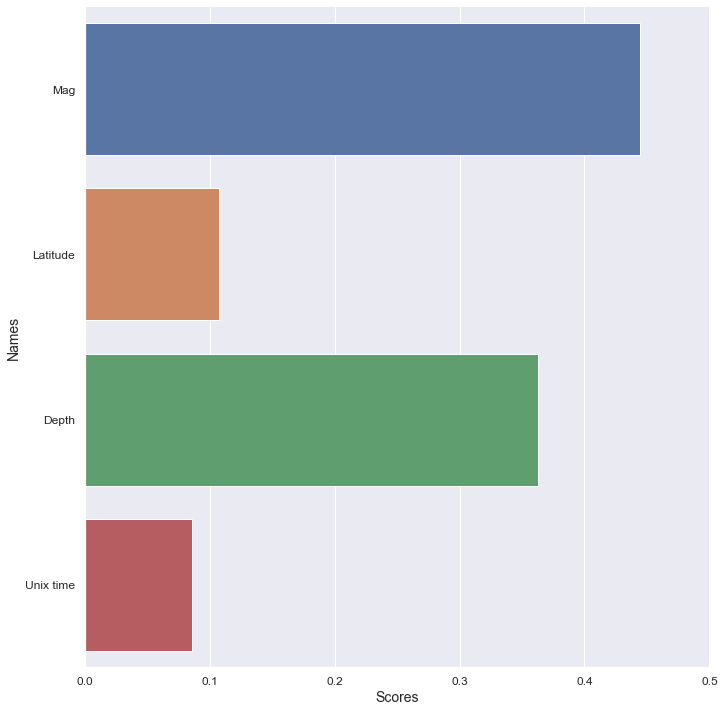

In [18]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['mag', 'latitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [19]:
#define number of splits fro cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3389  3390  3391 ... 33885 33886 33887] | test: [   0    1    2 ... 3386 3387 3388]
Train: [    0     1     2 ... 33885 33886 33887] | test: [3389 3390 3391 ... 6775 6776 6777]
Train: [    0     1     2 ... 33885 33886 33887] | test: [ 6778  6779  6780 ... 10164 10165 10166]
Train: [    0     1     2 ... 33885 33886 33887] | test: [10167 10168 10169 ... 13553 13554 13555]
Train: [    0     1     2 ... 33885 33886 33887] | test: [13556 13557 13558 ... 16942 16943 16944]
Train: [    0     1     2 ... 33885 33886 33887] | test: [16945 16946 16947 ... 20331 20332 20333]
Train: [    0     1     2 ... 33885 33886 33887] | test: [20334 20335 20336 ... 23720 23721 23722]
Train: [    0     1     2 ... 33885 33886 33887] | test: [23723 23724 23725 ... 27109 27110 27111]
Train: [    0     1     2 ... 33885 33886 33887] | test: [27112 27113 27114 ... 30497 30498 30499]
Train: [    0     1     2 ... 30497 30498 30499] | test: [30500 30501 30502 ... 33885 33886 33887]


In [20]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[ -7.5353609   -9.67515366 -12.8204702   -6.63606704  -9.9533601
 -12.60653117 -11.26882554 -11.19616     -9.95747106  -9.40977653]
MAE: -10.106 (1.885)


In [21]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [22]:
#create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

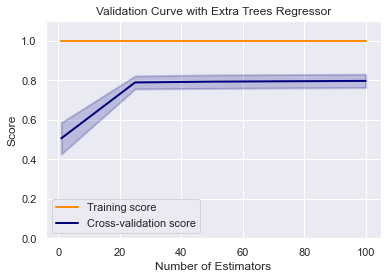

In [23]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [25]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lon = y_test
lons = actual_lon['longitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lons, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 30.511
MAE: 8.804


In [26]:
#make dataframe with actual test values and ML predicted ones
lon_pred = actual_lon
lon_pred['Predicted'] = testpredict


In [27]:
lon_pred_all = lon_pred.rename(columns={'longitude': 'Actual'})

In [28]:
lon_pred_all.head(5)

,Actual,Predicted
8338,-121.142333,-114.509038
8426,161.043300,75.869071
3079,-119.622500,-119.664068
5192,-122.819336,-122.825543
32429,-175.527600,-94.185900


In [29]:
#join dataframes for actual and predicted with original dataframe
lon_pred_all = lon_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lon_pred_all = lon_pred_all.rename(columns={'longitude_x': 'Actual', 'longitude_y': 'longitude'})
lon_pred_all.head(5)

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
8338,-121.142333,-114.509038,2021-12-07 15:32:01.140000+00:00,36.562500,-121.142333,4.35,1.38,md,14.0,120.00,...,"3km N of Pinnacles, CA",earthquake,0.28,1.49,0.327,13.0,reviewed,nc,nc,1.638891e+09
8426,161.043300,75.869071,2021-12-07 10:28:00.447000+00:00,-9.963400,161.043300,170.33,5.40,mww,NaN,25.00,...,"110 km WNW of Kirakira, Solomon Islands",earthquake,4.70,5.80,0.098,10.0,reviewed,us,us,1.638873e+09
3079,-119.622500,-119.664068,2021-12-24 04:06:37.017000+00:00,40.160500,-119.622500,6.20,0.30,ml,3.0,241.35,...,"23 km N of Sutcliffe, Nevada",earthquake,NaN,8.30,0.000,1.0,reviewed,nn,nn,1.640319e+09
5192,-122.819336,-122.825543,2021-12-17 20:17:55.100000+00:00,38.839832,-122.819336,1.36,0.65,md,22.0,56.00,...,"9km WNW of Cobb, CA",earthquake,0.22,0.51,0.270,4.0,automatic,nc,nc,1.639772e+09
32429,-175.527600,-94.185900,2022-02-19 14:45:11.512000+00:00,-23.717300,-175.527600,10.00,5.10,mb,NaN,154.00,...,"270 km SSW of ‘Ohonua, Tonga",earthquake,7.40,1.80,0.092,38.0,reviewed,us,us,1.645282e+09


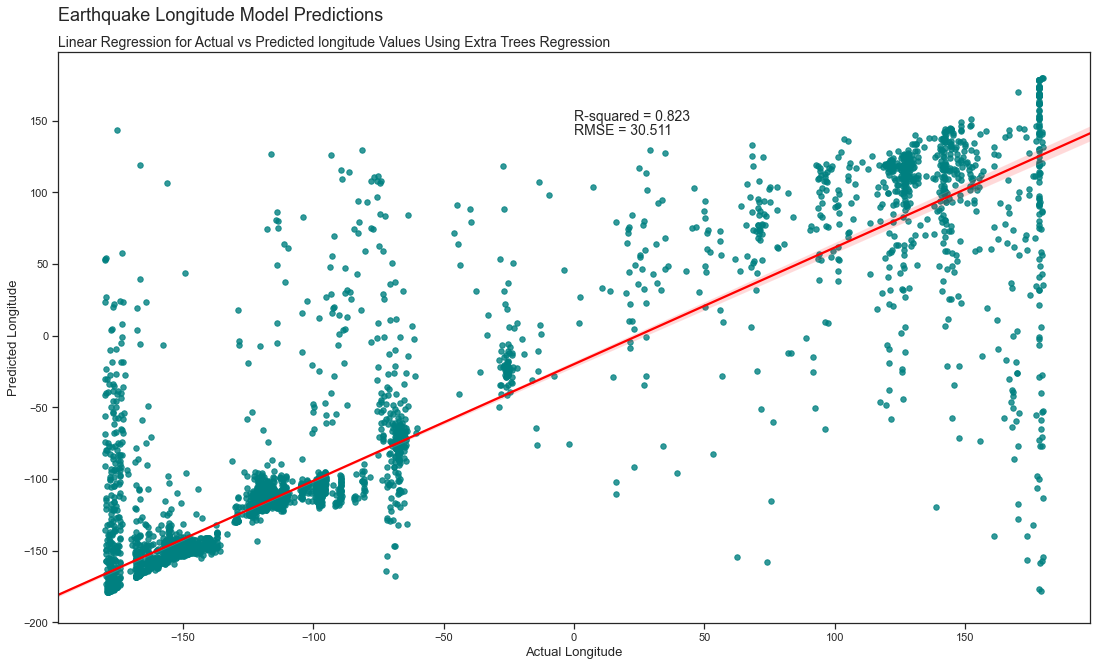

In [30]:
#plot actual vs predicted values
x = np.array(lon_pred_all['longitude'])
y = np.array(testpredict)
# r2_score(y_test, y_pred)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Longitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted longitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lon_pred_all['longitude'], testpredict)), (0, 150),  fontsize=14)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 140), fontsize=14)

fig.savefig('../static/images/extratrees_lon_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [31]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lat = float(input('Enter a latitude (in decimal form; negative for south hemisphere): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lat,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 45.0017


Test with new data from USGS


In [32]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-18T23:17:29.390Z,36.564167,-121.095833,6.000000,1.78,md,11.0,121.00,0.047500,0.12,...,2022-03-18T23:28:10.634Z,"6km NE of Pinnacles, CA",earthquake,0.48,1.12,0.130000,11.0,automatic,nc,nc
1,2022-03-18T23:12:44.580Z,35.860833,-117.681167,7.860000,0.88,ml,17.0,83.00,0.081520,0.07,...,2022-03-18T23:30:08.604Z,"22km ESE of Little Lake, CA",earthquake,0.13,0.37,0.117000,9.0,reviewed,ci,ci
2,2022-03-18T22:59:59.356Z,64.959600,-147.297700,5.500000,1.40,ml,NaN,NaN,NaN,0.30,...,2022-03-18T23:02:29.973Z,"15 km E of Fox, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
3,2022-03-18T22:31:46.680Z,38.801834,-122.772499,1.640000,0.84,md,8.0,231.00,0.010060,0.02,...,2022-03-18T22:50:12.387Z,"3km NNW of The Geysers, CA",earthquake,1.38,0.73,NaN,1.0,automatic,nc,nc
4,2022-03-18T22:25:25.619Z,37.058500,-117.355000,8.500000,1.30,ml,8.0,118.89,0.063000,0.19,...,2022-03-18T22:45:42.858Z,"55 km WNW of Beatty, Nevada",earthquake,NaN,2.60,1.040000,6.0,reviewed,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2022-03-17T23:48:33.060Z,19.194166,-155.435165,31.850000,2.00,md,35.0,148.00,NaN,0.11,...,2022-03-17T23:51:45.340Z,"4 km ESE of Pāhala, Hawaii",earthquake,0.63,0.73,0.550000,12.0,automatic,hv,hv
292,2022-03-17T23:47:11.504Z,62.749400,-148.899300,0.000000,2.20,ml,NaN,NaN,NaN,0.82,...,2022-03-17T23:53:58.877Z,"70 km ENE of Chase, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
293,2022-03-17T23:46:17.450Z,34.437333,-119.134000,13.660000,1.19,ml,10.0,178.00,0.002922,0.16,...,2022-03-17T23:54:48.366Z,"10km E of Ojai, CA",earthquake,0.65,0.87,0.136000,6.0,reviewed,ci,ci
294,2022-03-17T23:44:25.260Z,60.032000,-153.096167,-1.170000,0.79,ml,5.0,162.00,NaN,0.04,...,2022-03-18T20:56:39.870Z,"62 km ENE of Pedro Bay, Alaska",earthquake,0.28,0.78,0.323555,6.0,reviewed,av,av


In [33]:
#create unix time column and drop columns not needed

test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df



,latitude,longitude,depth,mag,Unix Time
0,36.564167,-121.095833,6.000000,1.78,1.647645e+09
1,35.860833,-117.681167,7.860000,0.88,1.647645e+09
2,64.959600,-147.297700,5.500000,1.40,1.647644e+09
3,38.801834,-122.772499,1.640000,0.84,1.647643e+09
4,37.058500,-117.355000,8.500000,1.30,1.647642e+09
...,...,...,...,...,...
291,19.194166,-155.435165,31.850000,2.00,1.647561e+09
292,62.749400,-148.899300,0.000000,2.20,1.647561e+09
293,34.437333,-119.134000,13.660000,1.19,1.647561e+09
294,60.032000,-153.096167,-1.170000,0.79,1.647561e+09


In [34]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [35]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['longitude'], axis = 1)

y_test_data = cleaned_test_df[['longitude']]


In [36]:
#predict values with best model
pred_data_y = best_model.predict(X_test_data)


In [37]:
#create dataframe with values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,36.564167,-121.095833,6.000000,1.78,1.647645e+09,-105.838630
1,35.860833,-117.681167,7.860000,0.88,1.647645e+09,-117.419428
2,64.959600,-147.297700,5.500000,1.40,1.647644e+09,-148.732732
3,38.801834,-122.772499,1.640000,0.84,1.647643e+09,-122.773126
4,37.058500,-117.355000,8.500000,1.30,1.647642e+09,-114.872897
...,...,...,...,...,...,...
291,19.194166,-155.435165,31.850000,2.00,1.647561e+09,-155.421251
292,62.749400,-148.899300,0.000000,2.20,1.647561e+09,-149.392855
293,34.437333,-119.134000,13.660000,1.19,1.647561e+09,-118.692987
294,60.032000,-153.096167,-1.170000,0.79,1.647561e+09,-152.012041


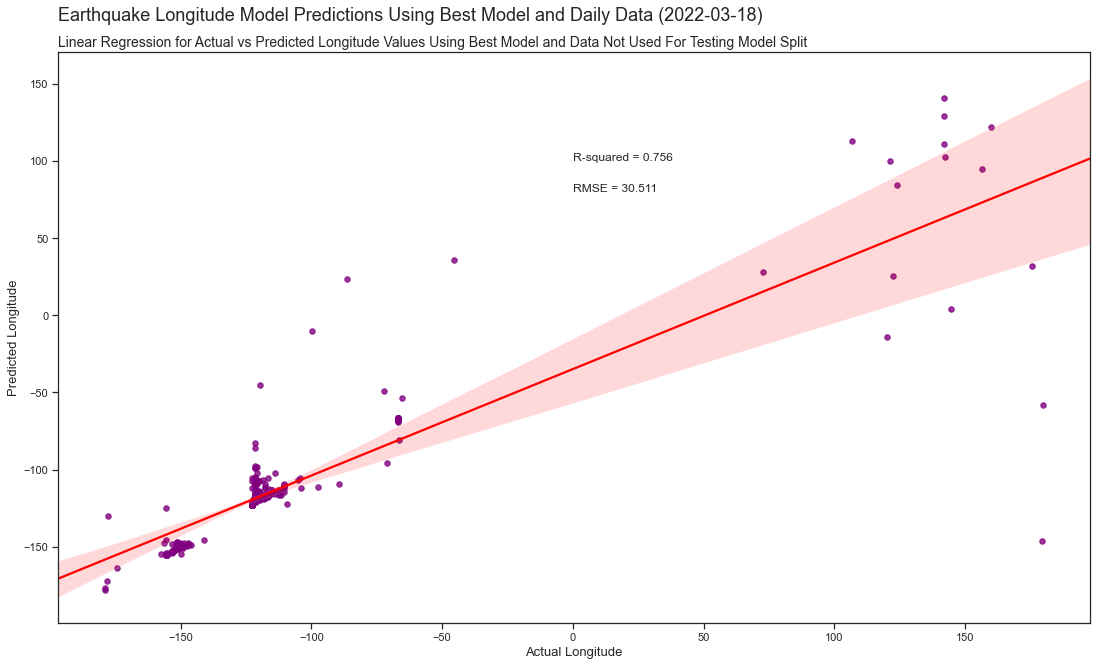

In [38]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['longitude'])
y = np.array(test_pred_data['Predicted'])

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Longitude', fontsize=13)
plt.xlabel('Actual Longitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Longitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Longitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 100),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 80), fontsize=12)

fig.savefig('../static/images/extratrees_lon_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lon_pred_all.to_sql('earthquake_etrees_lon', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lon_pred_all.to_sql('earthquake_etrees_lon', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()